<a href="https://colab.research.google.com/github/ishwerdutt/pytorch/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [3]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 78320ishu (ishu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


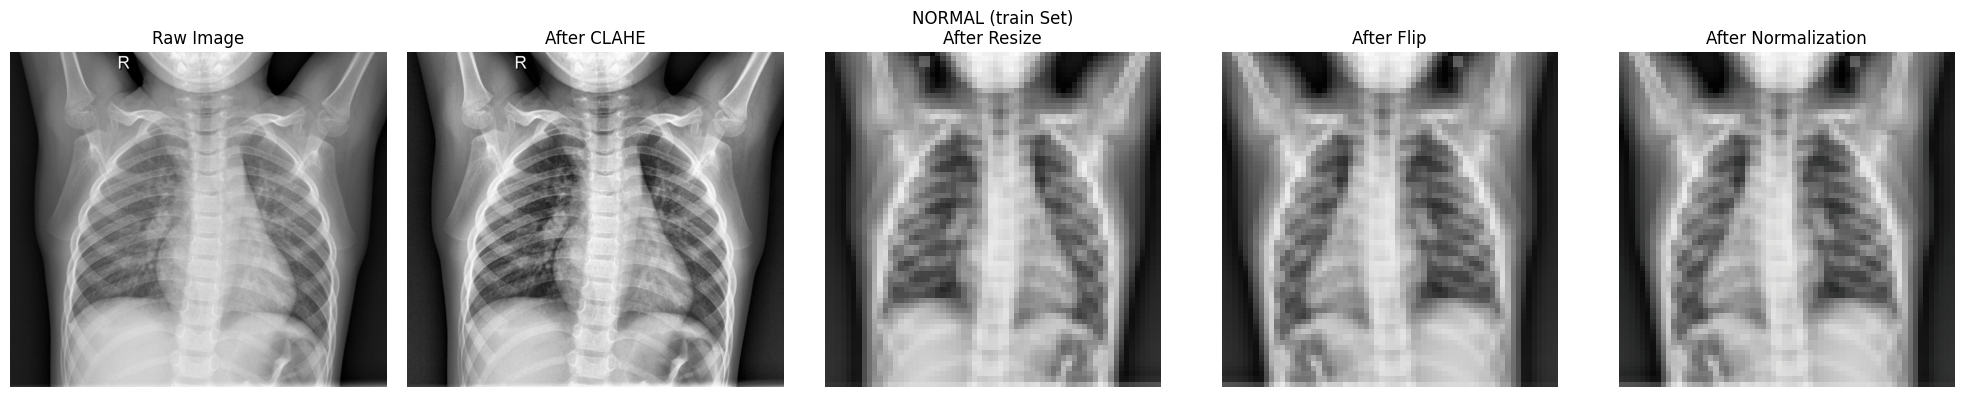

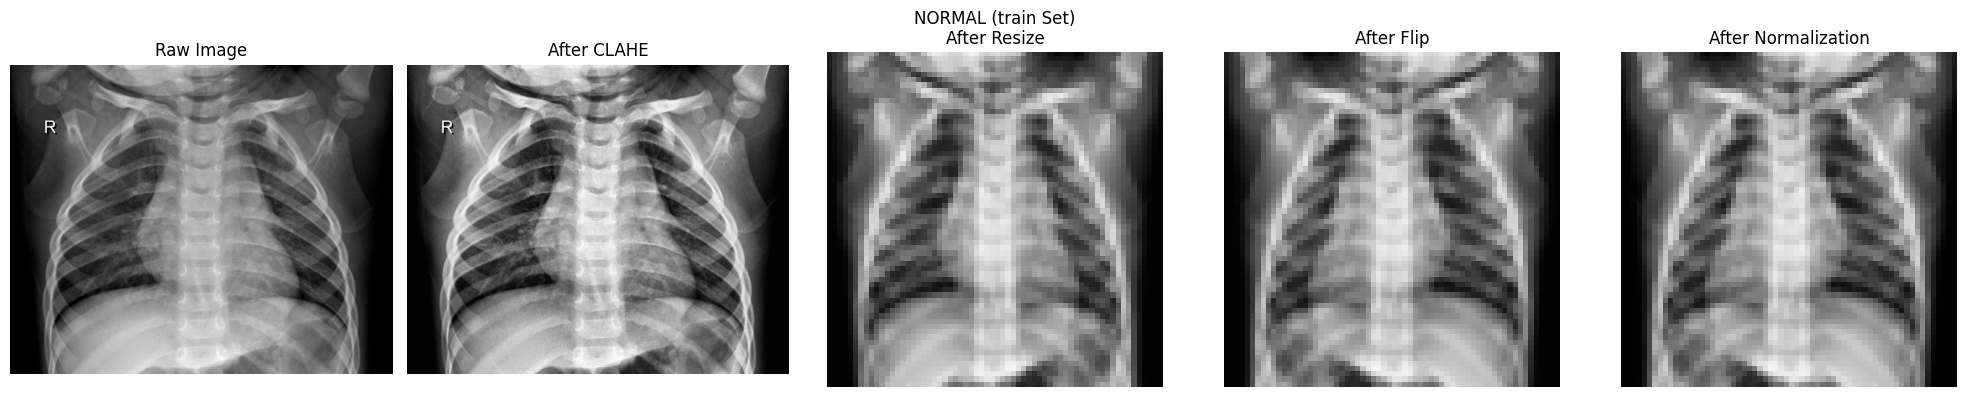

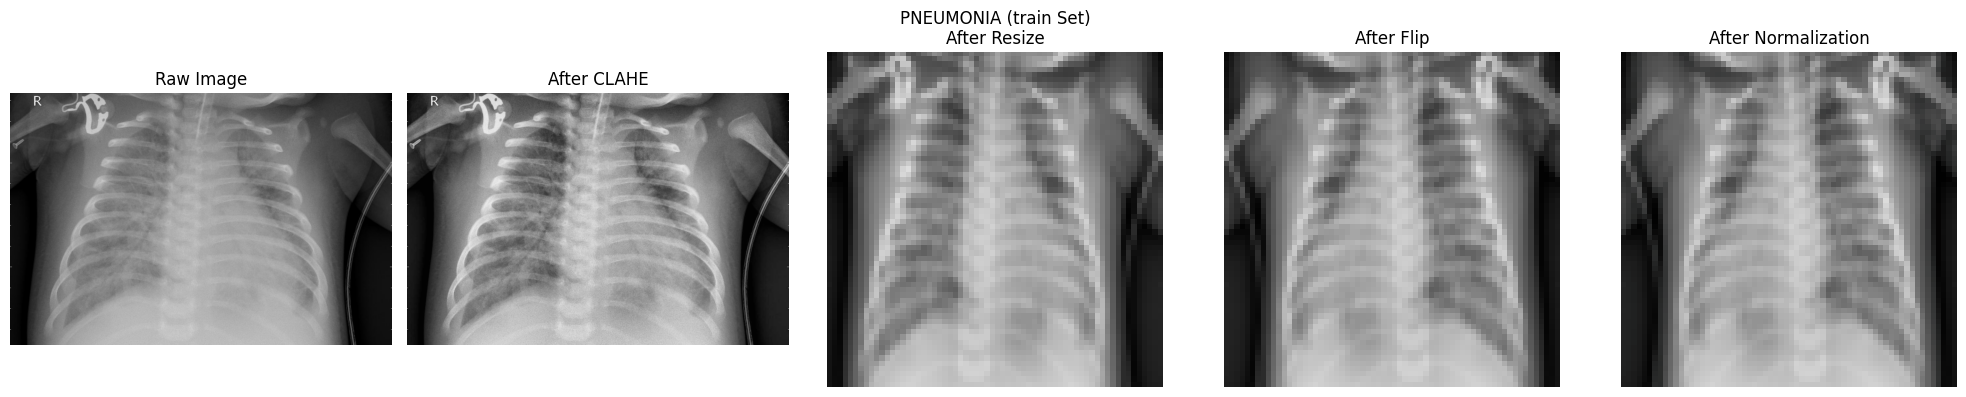

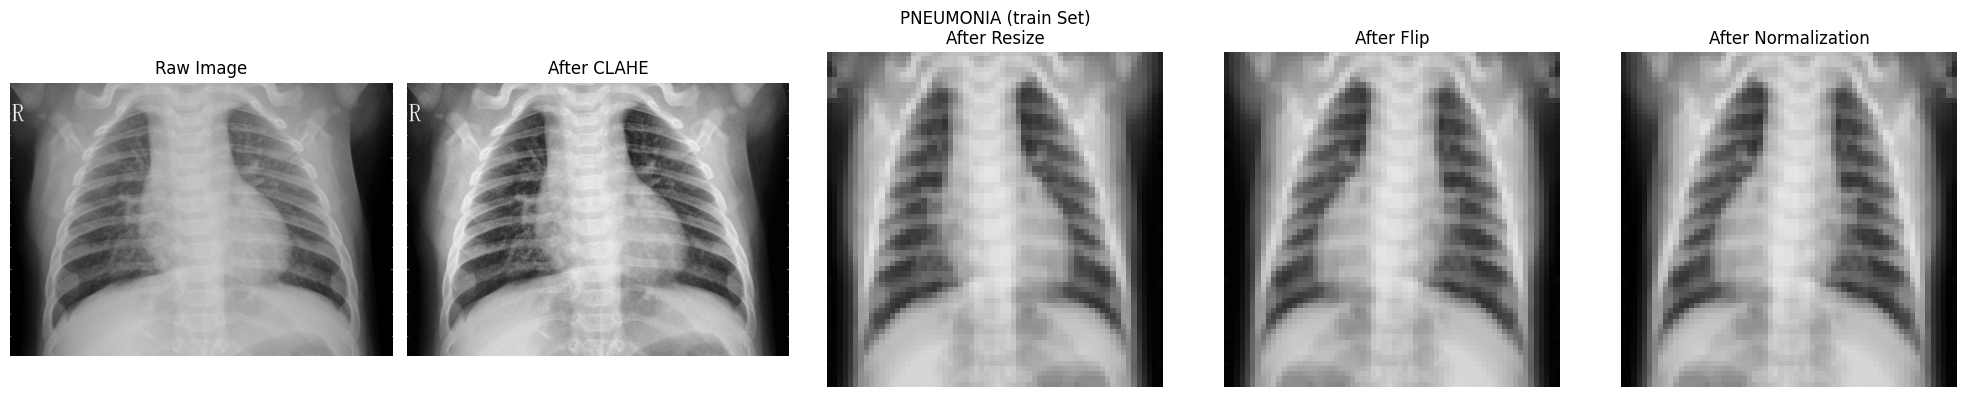

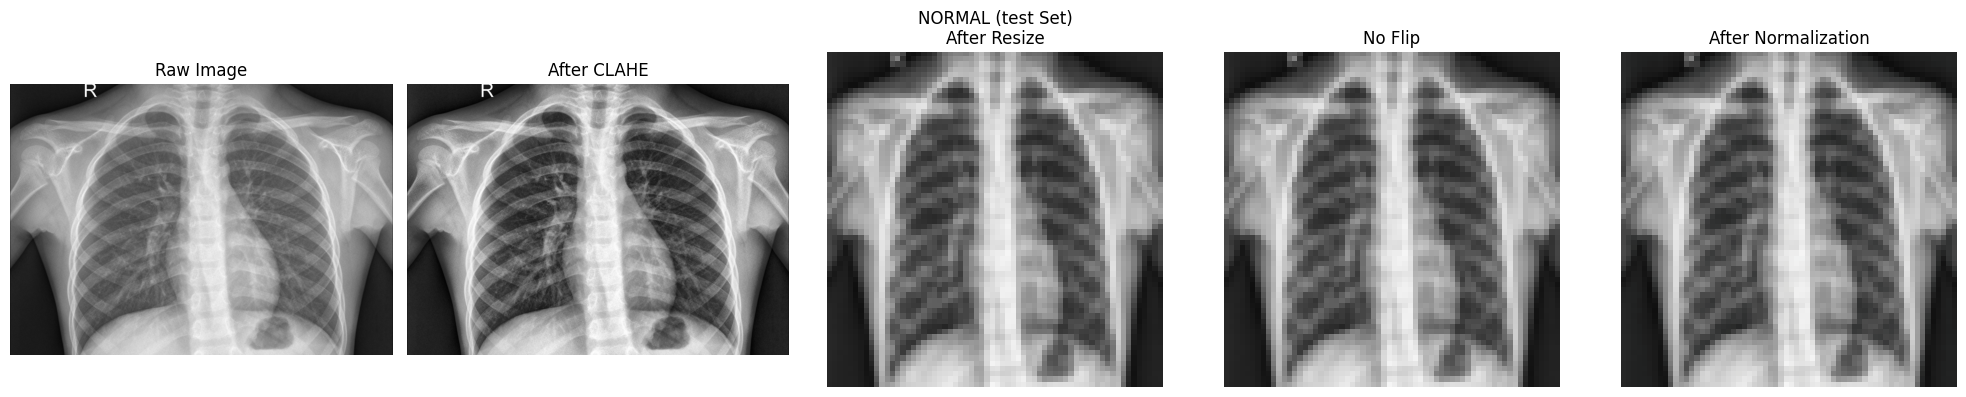

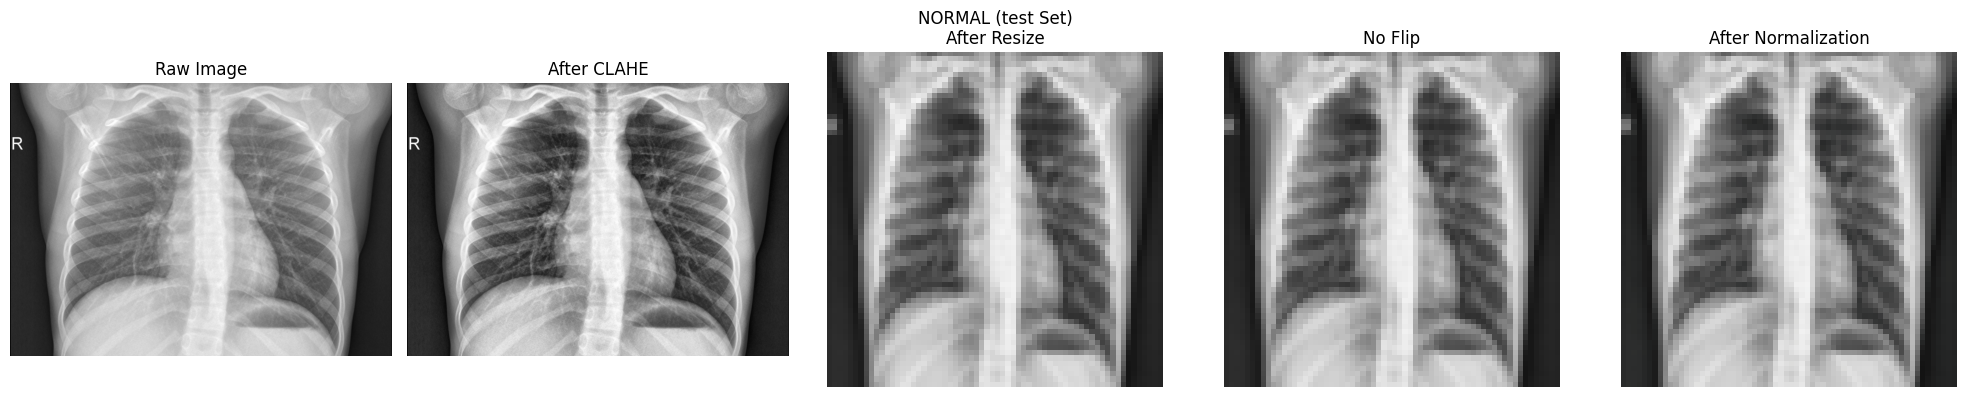

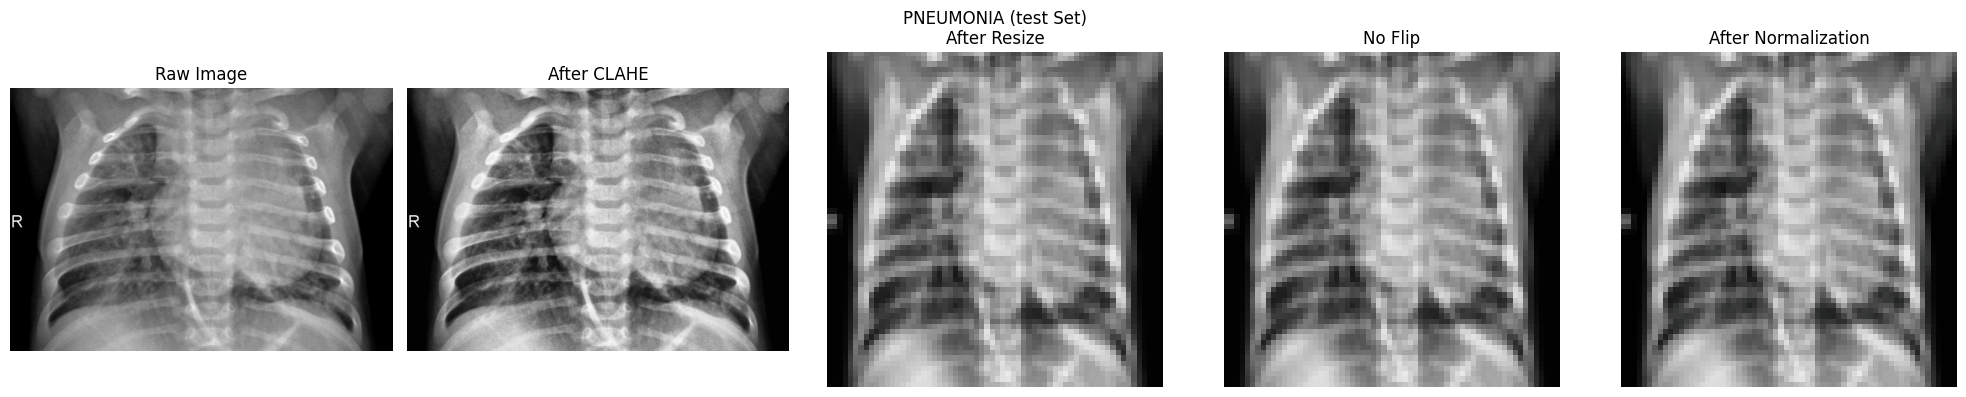

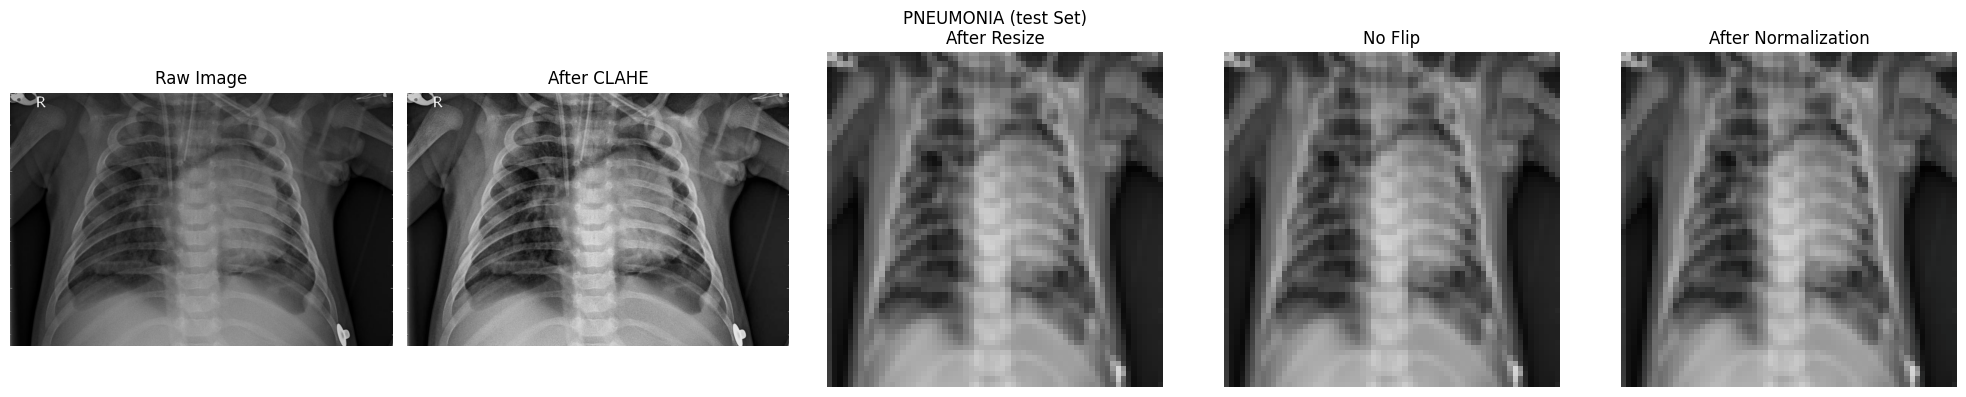

In [22]:
def visualize_transformations(dataset, phase, num_samples=4, output_dir="visualizations"):
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Select samples (2 NORMAL, 2 PNEUMONIA)
    normal_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == 0][:num_samples//2]
    pneumonia_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == 1][:num_samples//2]
    sample_indices = normal_indices + pneumonia_indices

    # Transformation steps
    resize_transform = transforms.Resize(size=(config["image_size"], config["image_size"]))
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    for idx in sample_indices:
        # Load raw image
        img_path, label = dataset.samples[idx]
        raw_image = Image.open(img_path).convert('RGB')

        # Apply transformations step-by-step
        clahe_image = preprocess_image(raw_image)
        resized_image = resize_transform(clahe_image)

        # Handle RandomHorizontalFlip (force apply for visualization in train)
        flipped_image = resized_image
        if phase == TRAIN:
            flipped_image = transforms.RandomHorizontalFlip(p=1.0)(resized_image)  # Force flip for demo

        # Convert to tensor and normalize
        tensor_image = to_tensor(flipped_image if phase == TRAIN else resized_image)
        normalized_image = normalize(tensor_image)

        # Reverse normalization for visualization
        denorm_image = normalized_image.clone()
        for t, m, s in zip(denorm_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
            t.mul_(s).add_(m)
        denorm_image = denorm_image.permute(1, 2, 0).numpy()

        # Plot all stages
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        axes[0].imshow(raw_image)
        axes[0].set_title('Raw Image')
        axes[0].axis('off')

        axes[1].imshow(clahe_image)
        axes[1].set_title('After CLAHE')
        axes[1].axis('off')

        axes[2].imshow(resized_image)
        axes[2].set_title('After Resize')
        axes[2].axis('off')

        axes[3].imshow(flipped_image if phase == TRAIN else resized_image)
        axes[3].set_title('After Flip' if phase == TRAIN else 'No Flip')
        axes[3].axis('off')

        axes[4].imshow(denorm_image)
        axes[4].set_title('After Normalization')
        axes[4].axis('off')

        plt.suptitle(f'{dataset.classes[label]} ({phase} Set)')
        plt.tight_layout()

        # Save and display
        output_path = os.path.join(output_dir, f'{phase}_{dataset.classes[label]}_{idx}.png')
        plt.savefig(output_path)
        plt.show()
        plt.close()

# Visualize transformations for train and test sets
visualize_transformations(trainset, TRAIN, num_samples=4)
visualize_transformations(testset, TEST, num_samples=4)


In [54]:
# Define hyperparameters for W&B
config = {
    "learning_rate": 0.001,
    "batch_size": 128,
    "epochs": 5,
    "image_size": 64,
    "architecture": "SimpleCNN",
    "dataset": "chest-xray-pneumonia",
    "optimizer": "Adam",
    "class_weights": [3.0, 1.0]
}


In [31]:
# Preprocessing and Transforms
def advanced_data_transforms(phase=None):
    if phase == TRAIN:
        return transforms.Compose([
            transforms.Resize(size=(config["image_size"], config["image_size"])),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    elif phase in [TEST, VAL]:
        return transforms.Compose([
            transforms.Resize(size=(config["image_size"], config["image_size"])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

def preprocess_image(image):
    if not isinstance(image, Image.Image):
        image = TF.to_pil_image(image)
    image_np = np.array(image)
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(4, 4))
    enhanced = clahe.apply(gray)
    enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(enhanced_rgb)

class CustomImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = self.loader(path)
        image = preprocess_image(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, target


In [32]:
trainset = CustomImageFolder(os.path.join(data_dir, TRAIN), transform=advanced_data_transforms(TRAIN))
testset = CustomImageFolder(os.path.join(data_dir, TEST), transform=advanced_data_transforms(TEST))
validset = CustomImageFolder(os.path.join(data_dir, VAL), transform=advanced_data_transforms(VAL))

train_loader = DataLoader(trainset, batch_size=config["batch_size"], shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(validset, batch_size=config["batch_size"], shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(testset, batch_size=config["batch_size"], shuffle=False, num_workers=4, pin_memory=True)


In [55]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [56]:
wandb.init(project="pneumonia-classification", config=config)


In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=2).to(device)
class_weights = torch.tensor(config["class_weights"]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
scaler = GradScaler()

<ipython-input-57-69b673419516>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [52]:
print(trainset.classes)  # Should output: ['NORMAL', 'PNEUMONIA']
print(trainset.class_to_idx)  # Should output: {'NORMAL': 0, 'PNEUMONIA': 1}

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


In [58]:
wandb.watch(model, criterion, log="all", log_freq=100)

# Training Loop
for epoch in range(config["epochs"]):
    model.train()
    running_loss = 0.0
    train_preds, train_true = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_true, train_preds)
    train_f1 = f1_score(train_true, train_preds, average='binary')
    train_precision = precision_score(train_true, train_preds, average='binary')
    train_recall = recall_score(train_true, train_preds, average='binary')

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_true = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_true, val_preds)
    val_f1 = f1_score(val_true, val_preds, average='binary')
    val_precision = precision_score(val_true, val_preds, average='binary')
    val_recall = recall_score(val_true, val_preds, average='binary')

    # Print metrics to Colab console
    print(f'\nEpoch {epoch+1}/{config["epochs"]}:')
    print('Train Metrics:')
    print(f'  Loss: {running_loss/len(train_loader):.4f}')
    print(f'  Accuracy: {train_acc:.4f}')
    print(f'  F1 Score: {train_f1:.4f}')
    print(f'  Precision: {train_precision:.4f}')
    print(f'  Recall: {train_recall:.4f}')
    print('Validation Metrics:')
    print(f'  Loss: {val_loss/len(val_loader):.4f}')
    print(f'  Accuracy: {val_acc:.4f}')
    print(f'  F1 Score: {val_f1:.4f}')
    print(f'  Precision: {val_precision:.4f}')
    print(f'  Recall: {val_recall:.4f}')

    # Log train and validation metrics to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": running_loss / len(train_loader),
        "train_accuracy": train_acc,
        "train_f1": train_f1,
        "train_precision": train_precision,
        "train_recall": train_recall,
        "val_loss": val_loss / len(val_loader),
        "val_accuracy": val_acc,
        "val_f1": val_f1,
        "val_precision": val_precision,
        "val_recall": val_recall
    })

    # Log validation confusion matrix
    cm = confusion_matrix(val_true, val_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
    plt.title('Validation Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    wandb.log({"val_confusion_matrix": wandb.Image(plt)})
    plt.close()


<ipython-input-58-59a5431825a8>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 1/5:
Train Metrics:
  Loss: 0.3130
  Accuracy: 0.8551
  F1 Score: 0.8976
  Precision: 0.9442
  Recall: 0.8555
Validation Metrics:
  Loss: 0.4151
  Accuracy: 0.8750
  F1 Score: 0.8889
  Precision: 0.8000
  Recall: 1.0000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-58-59a5431825a8>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current


Epoch 2/5:
Train Metrics:
  Loss: 0.1403
  Accuracy: 0.9417
  F1 Score: 0.9599
  Precision: 0.9814
  Recall: 0.9394
Validation Metrics:
  Loss: 0.4827
  Accuracy: 0.8750
  F1 Score: 0.8889
  Precision: 0.8000
  Recall: 1.0000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-58-59a5431825a8>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current


Epoch 3/5:
Train Metrics:
  Loss: 0.1143
  Accuracy: 0.9561
  F1 Score: 0.9700
  Precision: 0.9867
  Recall: 0.9538
Validation Metrics:
  Loss: 0.7130
  Accuracy: 0.8125
  F1 Score: 0.8421
  Precision: 0.7273
  Recall: 1.0000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-58-59a5431825a8>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current


Epoch 4/5:
Train Metrics:
  Loss: 0.0924
  Accuracy: 0.9620
  F1 Score: 0.9741
  Precision: 0.9894
  Recall: 0.9592
Validation Metrics:
  Loss: 0.7810
  Accuracy: 0.7500
  F1 Score: 0.8000
  Precision: 0.6667
  Recall: 1.0000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-58-59a5431825a8>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current


Epoch 5/5:
Train Metrics:
  Loss: 0.0828
  Accuracy: 0.9668
  F1 Score: 0.9774
  Precision: 0.9902
  Recall: 0.9649
Validation Metrics:
  Loss: 0.7611
  Accuracy: 0.8125
  F1 Score: 0.8421
  Precision: 0.7273
  Recall: 1.0000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test Metrics:
  Loss: 0.7722
  Accuracy: 0.7885
  F1 Score: 0.8540
  Precision: 0.7510
  Recall: 0.9897


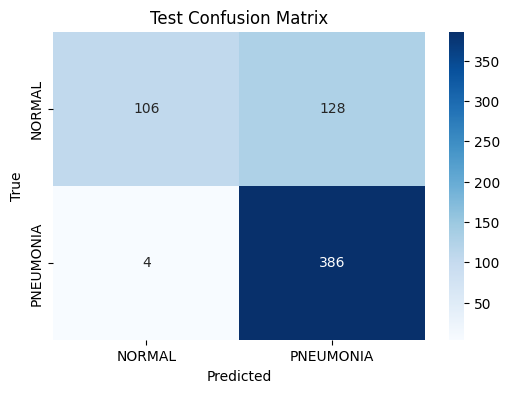

epoch,▁▃▅▆█
test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▆▇██
train_f1,▁▆▇██
train_loss,█▃▂▁▁
train_precision,▁▇▇██
train_recall,▁▆▇██


In [59]:
# Test Evaluation
model.eval()
test_loss = 0.0
test_preds, test_true = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

# Compute all test metrics
test_acc = accuracy_score(test_true, test_preds)
test_f1 = f1_score(test_true, test_preds, average='binary')
test_precision = precision_score(test_true, test_preds, average='binary')
test_recall = recall_score(test_true, test_preds, average='binary')

# Print test metrics to Colab console
print('\nTest Metrics:')
print(f'  Loss: {test_loss/len(test_loader):.4f}')
print(f'  Accuracy: {test_acc:.4f}')
print(f'  F1 Score: {test_f1:.4f}')
print(f'  Precision: {test_precision:.4f}')
print(f'  Recall: {test_recall:.4f}')

# Log test metrics to W&B
wandb.log({
    "test_loss": test_loss / len(test_loader),
    "test_accuracy": test_acc,
    "test_f1": test_f1,
    "test_precision": test_precision,
    "test_recall": test_recall
})

# Log and display test confusion matrix
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.title('Test Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
wandb.log({"test_confusion_matrix": wandb.Image(plt)})
plt.savefig('test_confusion_matrix.png')
plt.show()
plt.close()

# Save model artifact
torch.save(model.state_dict(), "simple_cnn_pneumonia.pth")
artifact = wandb.Artifact("simple_cnn_pneumonia", type="model")
artifact.add_file("simple_cnn_pneumonia.pth")
wandb.log_artifact(artifact)

# Finish W&B run
wandb.finish()